In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

!pip install pmdarima
from pmdarima import AutoARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('parkingLot.csv').sort_values(by='timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp']) - pd.Timedelta(hours=2)
df['date'] = df['timestamp'].dt.date

df_entry = df[df['camera_id'] == 1].groupby('date')['camera_id'].count().rename('entries').to_frame()

print(df_entry)

            entries
date               
2024-09-12      886
2024-09-13      809
2024-09-14      925
2024-09-15     1073
2024-09-16      843
...             ...
2024-11-09      906
2024-11-10      944
2024-11-11      828
2024-11-12      806
2024-11-13      781

[63 rows x 1 columns]


In [ ]:
ts_entries = df_entry['entries']

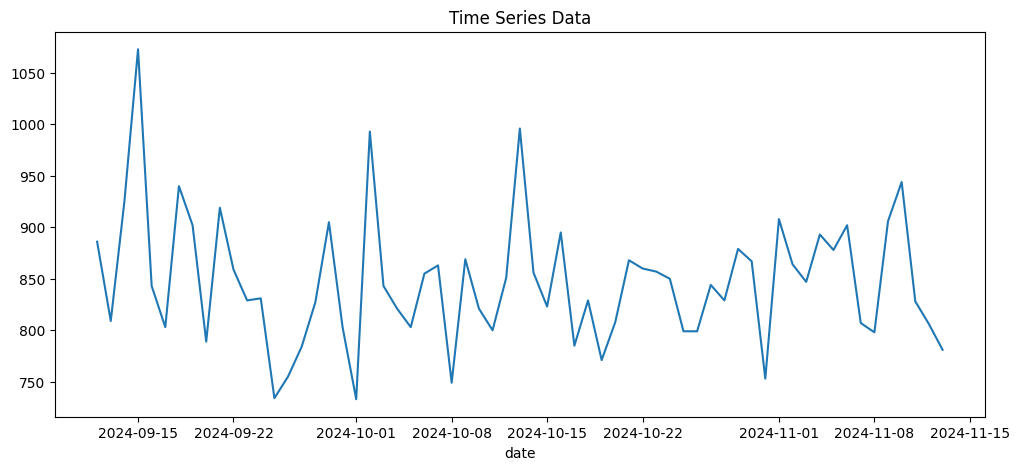

In [ ]:
ts_entries.plot(figsize=(12, 5))
plt.title('Time Series Data')
plt.show()

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

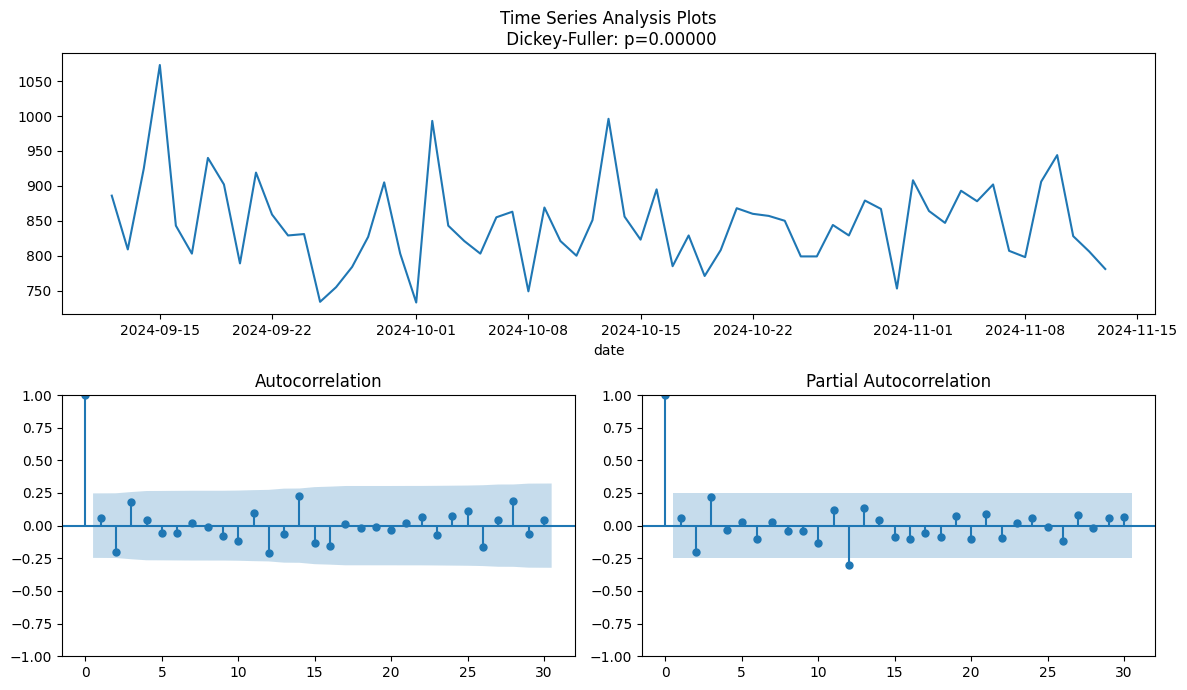

In [ ]:
tsplot(ts_entries, lags=30)

In [ ]:
result = adfuller(ts_entries)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.272952589041543
p-value: 1.570966499336647e-10


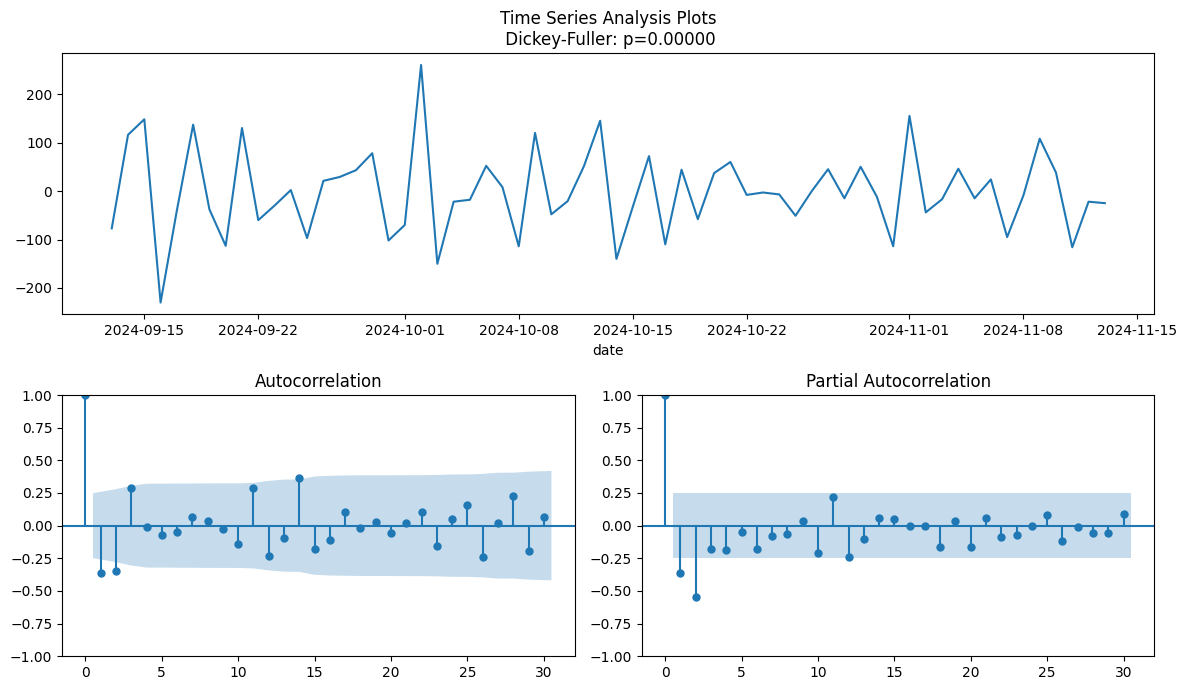

In [ ]:
tsplot(ts_entries.diff().dropna(), lags=30)

In [ ]:
result = adfuller(ts_entries.diff().dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.166272424113554
p-value: 6.977760526499671e-08


### It can be concluded that the given data is stationary and no difference term is required

In [ ]:
test_len = int(len(ts_entries) * 0.2)
entry_train, entry_test = ts_entries.iloc[:-test_len], ts_entries.iloc[-test_len:]

model = AutoARIMA(suppress_warnings=True, error_action='ignore', seasonal=True, m=7, stepwise=True)

model.fit(entry_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:                        SARIMAX   Log Likelihood                -285.816
Date:                Mon, 28 Oct 2024   AIC                            575.632
Time:                        12:23:44   BIC                            579.496
Sample:                    09-12-2024   HQIC                           577.109
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    844.9608     10.723     78.795      0.000     823.943     865.978
sigma2      4318.2338    726.227      5.946      0.000    2894.854    5741.613
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                15.07
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             1.00
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

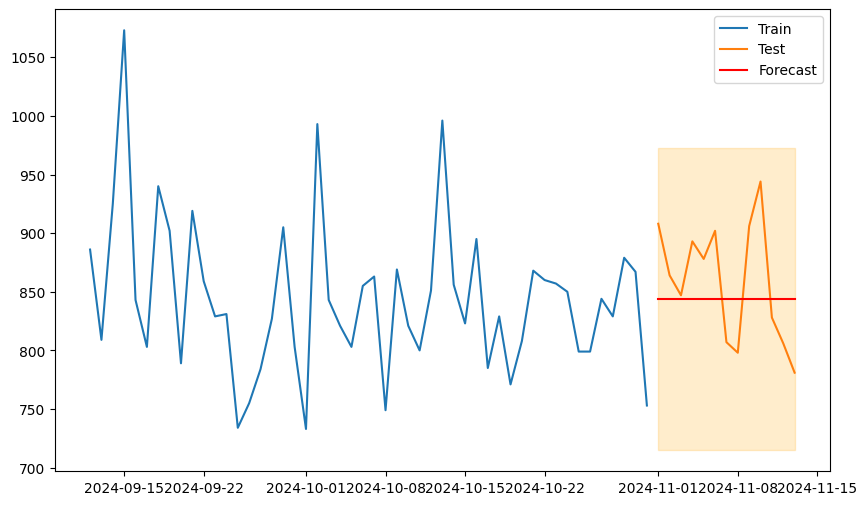

MAE: 45.45
MAPE: 5.24%


In [ ]:
train_size = int(len(ts_entries) * 0.8)
train, test = ts_entries[:train_size], ts_entries[train_size:]

model = AutoARIMA(suppress_warnings=True, error_action='ignore', seasonal=True, m=7, stepwise=True)
model.fit(train)

n_test = len(test)
forecast, conf_int = model.predict(n_periods=n_test, return_conf_int=True)
forecast_index = test.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
forecast_df['Lower CI'] = conf_int[:, 0]
forecast_df['Upper CI'] = conf_int[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='orange', alpha=0.2)
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

forecast_index = test.index
forecast_series = pd.Series(forecast, index=forecast_index)

mae = mean_absolute_error(test, forecast_series)

mape = np.mean(np.abs((test - forecast_series) / test)) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


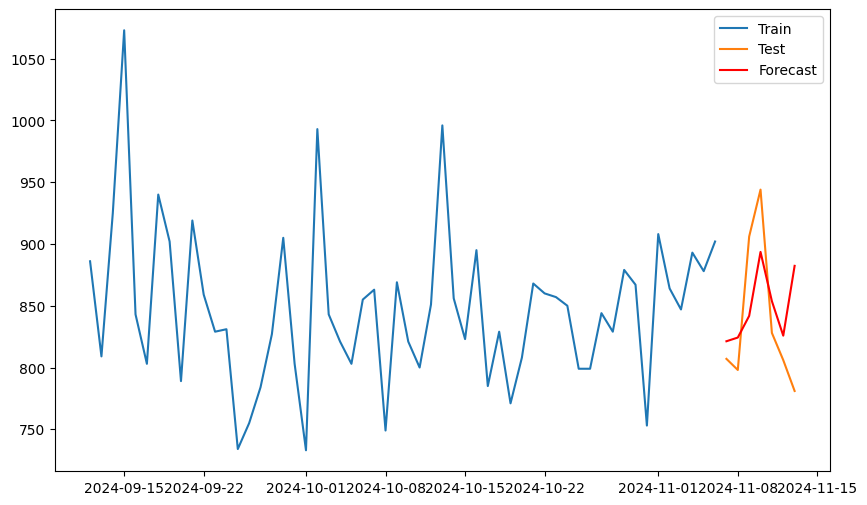

MAE: 43.14
MAPE: 5.15%


In [ ]:
train_size = int(len(ts_entries) * 0.9)
train, test = ts_entries[:train_size], ts_entries[train_size:]

ets_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=7)
ets_fitted = ets_model.fit()

n_periods = len(test)
forecast = ets_fitted.forecast(steps=n_periods)

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")